# Image segmentation

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [ ]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [ ]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2024-02-12 13:02:38--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2024-02-12 13:02:39--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0665829d4e55ca35afb163be6a.dl.dropboxusercontent.com/cd/0/inline/CNITvH9dH_Ckj4lTND5eD68eJt5hsEE2fBwBXOCgZYV14BkJONxO6SarTzFZdVB2eP_YYsmGI_7rdSLbOe1pqIjcc0jRGBezTcU9lZsJXmFn9cSVtjAJnCi56Noq5cw7KAE/file# [following]
--2024-02-12 13:02:40--  https://uc0665829d4e55ca35afb163be6a.dl.dropboxusercontent.com/cd/0/inline/CNITvH9dH_Ckj4lTND5eD68eJt5hsEE2fBwBXOCgZYV14BkJONxO6SarTzFZdVB2eP_YYsmGI

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

<ipython-input-3-ca992408d7b5>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_files[idx])
<ipython-input-3-ca992408d7b5>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_files[idx])


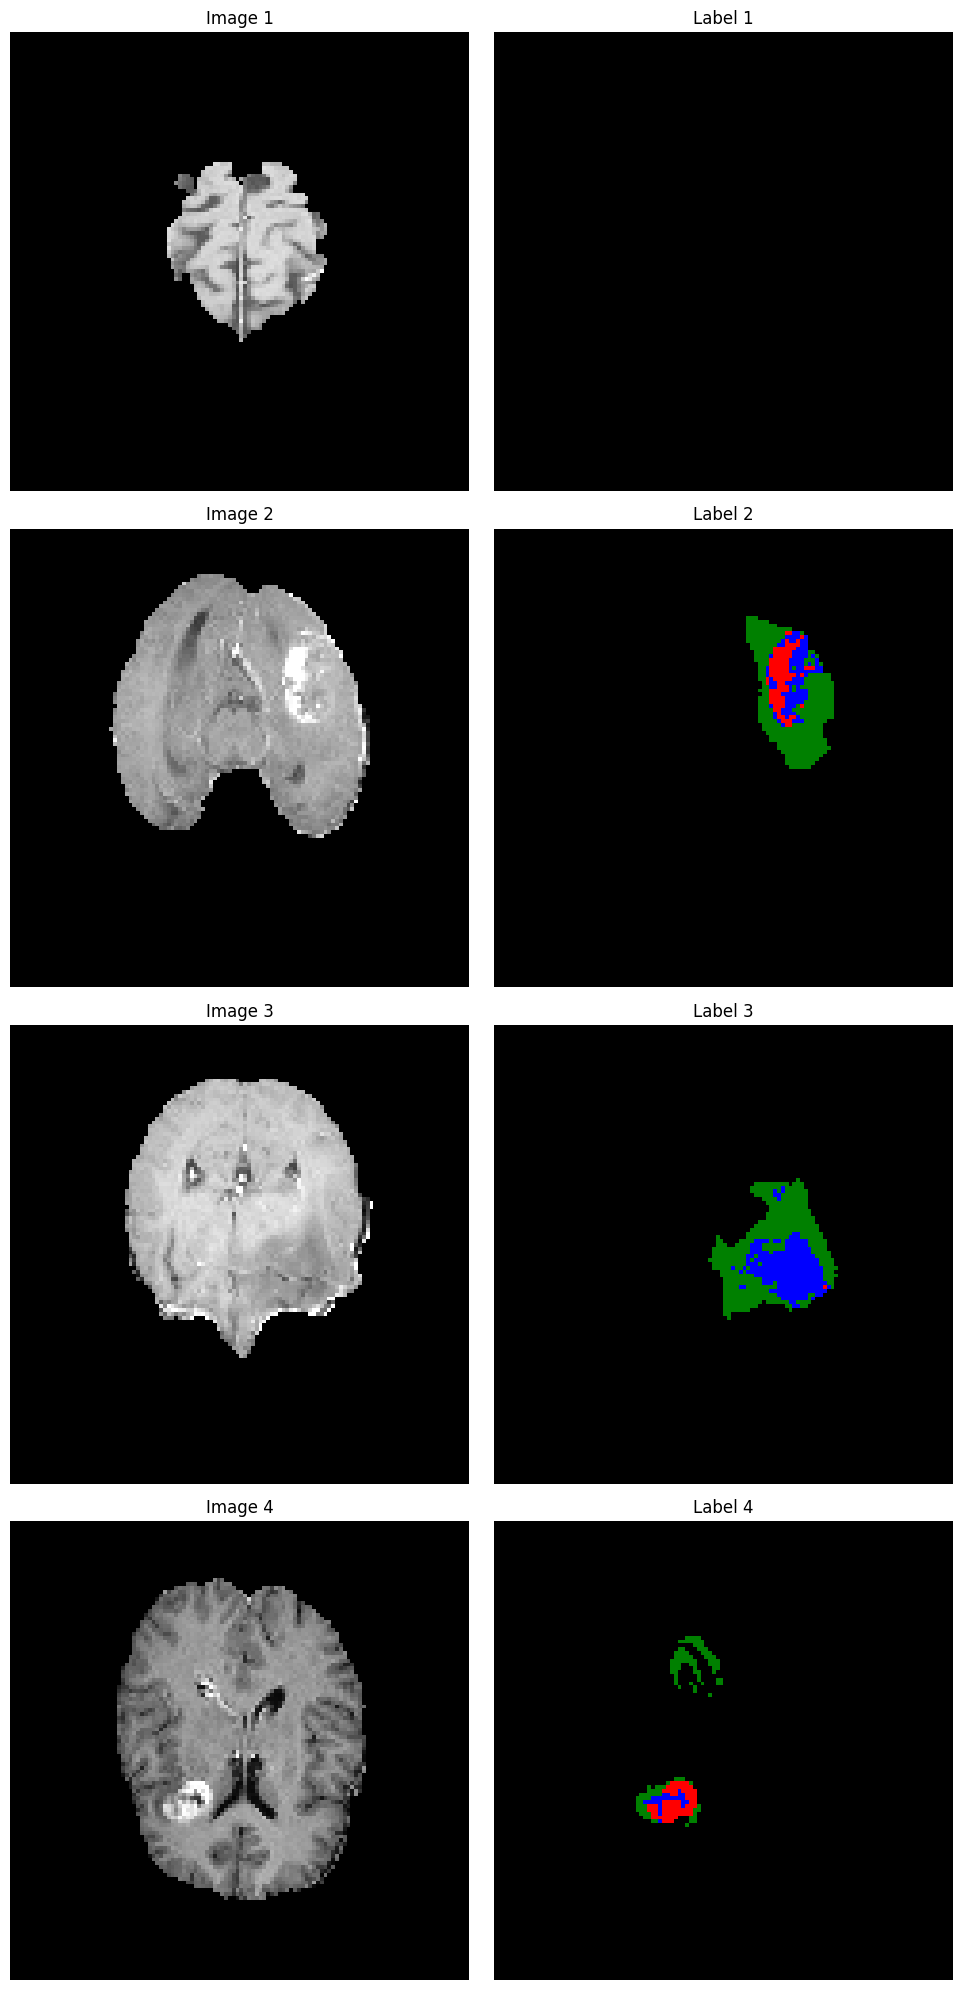

In [ ]:
### Insert your code ###

# Define picture directories
images_dir = './Task01_BrainTumour_2D/training_images'
labels_dir = './Task01_BrainTumour_2D/training_labels'

# Get the files from each of the directories
image_files = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.png')]
label_files = [os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith('.png')]

# Sort lists so images and labels match
image_files.sort()
label_files.sort()

# Randomly select indices
random_indices = random.sample(range(len(image_files)), 4)

# Visualise the images
figure, axes = plt.subplots(4, 2, figsize=(10, 20))

for i, idx in enumerate(random_indices):
  image = imageio.imread(image_files[idx])
  label = imageio.imread(label_files[idx])

  # Display image
  axes[i, 0].imshow(image, cmap='gray')
  axes[i, 0].axis('off')
  axes[i, 0].set_title(f'Image {i+1}')

  label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
  axes[i, 1].imshow(label, cmap=label_cmap)
  axes[i, 1].axis('off')
  axes[i, 1].set_title(f'Label {i+1}')

plt.tight_layout()
plt.show()

### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [ ]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###

        # Generate random indices
        random_indices = random.sample(range(self.__len__()), batch_size)

        # Get item for each index and append to lists
        for idx in random_indices:
          image, label = self.__getitem__(idx)
          images.append(image[np.newaxis, ...])
          labels.append(label)

        images = np.stack(images)
        labels = np.stack(labels)

        ### End of your code ###
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [ ]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        ### Insert your code ###

        # Every step in the expansive path consists of an upsampling of the
        # feature map followed by a 2x2 convolution (“up-convolution”) that halves the
        # number of feature channels, a concatenation with the correspondingly cropped
        # feature map from the contracting path, and two 3x3 convolutions,
        # each followed by a ReLU

        # Upsampling
        self.upconv3 = nn.ConvTranspose2d(n, int(n/2), kernel_size=2, stride=2)
        n //= 2
        # Two 3x3 convolutions, each followed by a ReLU
        self.d3 = nn.Sequential(
          nn.Conv2d(n*2, n, kernel_size=3, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU(),
          nn.Conv2d(n, n, kernel_size=3, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU()
        )

        # Upsampling
        self.upconv2 = nn.ConvTranspose2d(n, int(n/2), kernel_size=2, stride=2)
        n //= 2
        # Two 3x3 convolutions, each followed by a ReLU
        self.d2 = nn.Sequential(
          nn.Conv2d(n*2, n, kernel_size=3, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU(),
          nn.Conv2d(n, n, kernel_size=3, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU()
        )

        # Upsampling
        self.upconv1 = nn.ConvTranspose2d(n, int(n/2), kernel_size=2, stride=2)
        n //= 2
        # Two 3x3 convolutions, each followed by a ReLU
        self.d1 = nn.Sequential(
          nn.Conv2d(n*2, n, kernel_size=3, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU(),
          nn.Conv2d(n, n, kernel_size=3, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU()
        )

        # At the final layer a 1x1 convolution is used to map each
        # 64-component feature vector to the desired number of classes

        # Output layer
        self.outconv = nn.Conv2d(n, output_channel, kernel_size=1)

        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###

        x = self.upconv3(x)
        x = torch.cat([x, conv3_skip], dim=1)
        x = self.d3(x)

        x = self.upconv2(x)
        x = torch.cat([x, conv2_skip], dim=1)
        x = self.d2(x)

        x = self.upconv1(x)
        x = torch.cat([x, conv1_skip], dim=1)
        x = self.d1(x)

        # Output
        x = self.outconv(x)

        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [ ]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3) # Adaptive learning rates

# Segmentation loss
criterion = nn.CrossEntropyLoss() # Classification loss

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()

# Accumulate losses for each epoch
model_losses = []
test_losses = []

for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###

    # Calculate the loss between the labels and predictions
    loss = criterion(logits, labels)
    model_losses.append(loss.item())

    # Zeroing gradients after each iteration
    optimizer.zero_grad()

    try:
      # Initialise backpropagation
      loss.backward()

      # Update parameters
      optimizer.step()

    except Exception as e:
      print(f"An error occurred during training: {e} at {time.time() - start}")

    # Print loss
    print('Iteration {}/{}, Training loss: {:.4f}'.format(it, num_iter, loss.item()))

    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###

            # Get batch of test images
            test_images, test_labels = test_set.get_random_batch(eval_batch_size)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)

            test_logits = model(test_images)

            # Calculate the loss between the labels and predictions
            test_loss = criterion(test_logits, test_labels)
            test_losses.append(test_loss)

            # Print loss
            print('Iteration {}/{}, Test loss: {:.4f}'.format(it, num_iter, test_loss.item()))

            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))

print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda


<ipython-input-4-1f6aa9be7e2e>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
<ipython-input-4-1f6aa9be7e2e>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_name)


Streaming output truncated to the last 5000 lines.
Iteration 5052/10000, Training loss: 0.0134
Iteration 5053/10000, Training loss: 0.0152
Iteration 5054/10000, Training loss: 0.0147
Iteration 5055/10000, Training loss: 0.0140
Iteration 5056/10000, Training loss: 0.0102
Iteration 5057/10000, Training loss: 0.0117
Iteration 5058/10000, Training loss: 0.0091
Iteration 5059/10000, Training loss: 0.0194
Iteration 5060/10000, Training loss: 0.0121
Iteration 5061/10000, Training loss: 0.0163
Iteration 5062/10000, Training loss: 0.0113
Iteration 5063/10000, Training loss: 0.0148
Iteration 5064/10000, Training loss: 0.0129
Iteration 5065/10000, Training loss: 0.0071
Iteration 5066/10000, Training loss: 0.0121
Iteration 5067/10000, Training loss: 0.0115
Iteration 5068/10000, Training loss: 0.0127
Iteration 5069/10000, Training loss: 0.0147
Iteration 5070/10000, Training loss: 0.0154
Iteration 5071/10000, Training loss: 0.0106
Iteration 5072/10000, Training loss: 0.0111
Iteration 5073/10000, Tra

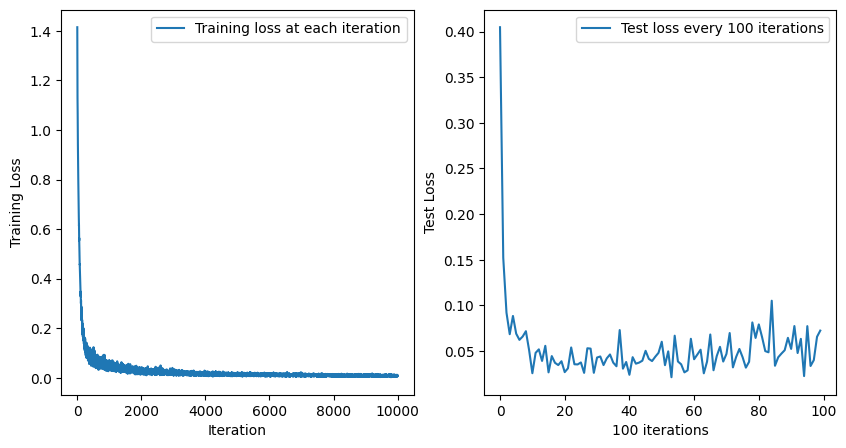

In [ ]:
# Printing loss progression
model_losses_cpu = [loss.cpu() if torch.is_tensor(loss) else loss for loss in model_losses]
test_losses_cpu = [loss.cpu() if torch.is_tensor(loss) else loss for loss in test_losses]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(model_losses_cpu, label="Training loss at each iteration")
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_losses_cpu, label="Test loss every 100 iterations")
plt.xlabel('100 iterations')
plt.ylabel('Test Loss')
plt.legend()

plt.show()

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

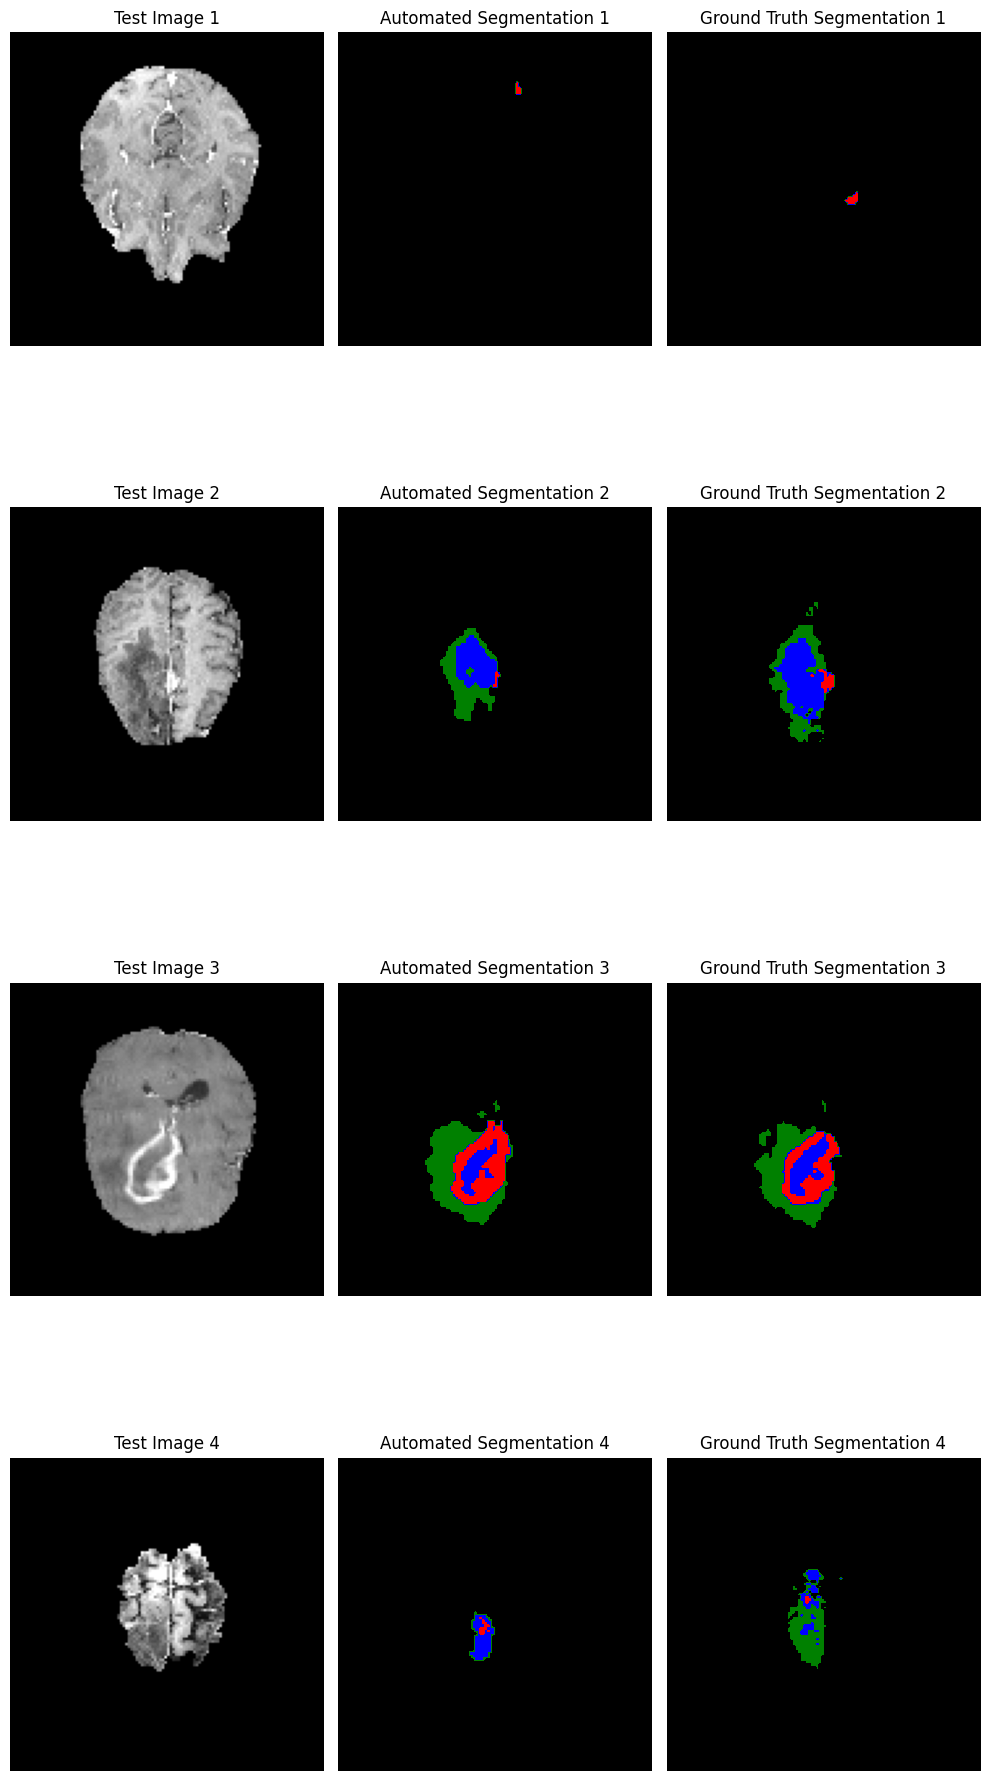

In [ ]:
### Insert your code ###

# Get 4 random test images
deploy_batch_size = 4
deploy_images, ground_truth_labels = test_set.get_random_batch(deploy_batch_size)
deploy_images, ground_truth_labels = torch.from_numpy(deploy_images), torch.from_numpy(ground_truth_labels)
deploy_images, ground_truth_labels = deploy_images.to(device, dtype=torch.float32), ground_truth_labels.to(device, dtype=torch.long)

# Deploy model on images
model.eval()
with torch.no_grad():
  deploy_logits = model(deploy_images)

# Convert logits to class predictions
predictions = torch.argmax(deploy_logits, dim=1)

# Visualise the images
figure, axes = plt.subplots(deploy_batch_size, 3, figsize=(10, 20))

with torch.no_grad():
  for i in range(deploy_batch_size):
    image = deploy_images[i].cpu().numpy().squeeze(0)
    label = ground_truth_labels[i].cpu().numpy()
    prediction = predictions[i].cpu().numpy()

    # Display image
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Test Image {i+1}')

    label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
    axes[i, 1].imshow(prediction, cmap=label_cmap)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Automated Segmentation {i+1}')

    axes[i, 2].imshow(label, cmap=label_cmap)
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f'Ground Truth Segmentation {i+1}')

plt.tight_layout()
plt.show()

### End of your code ###

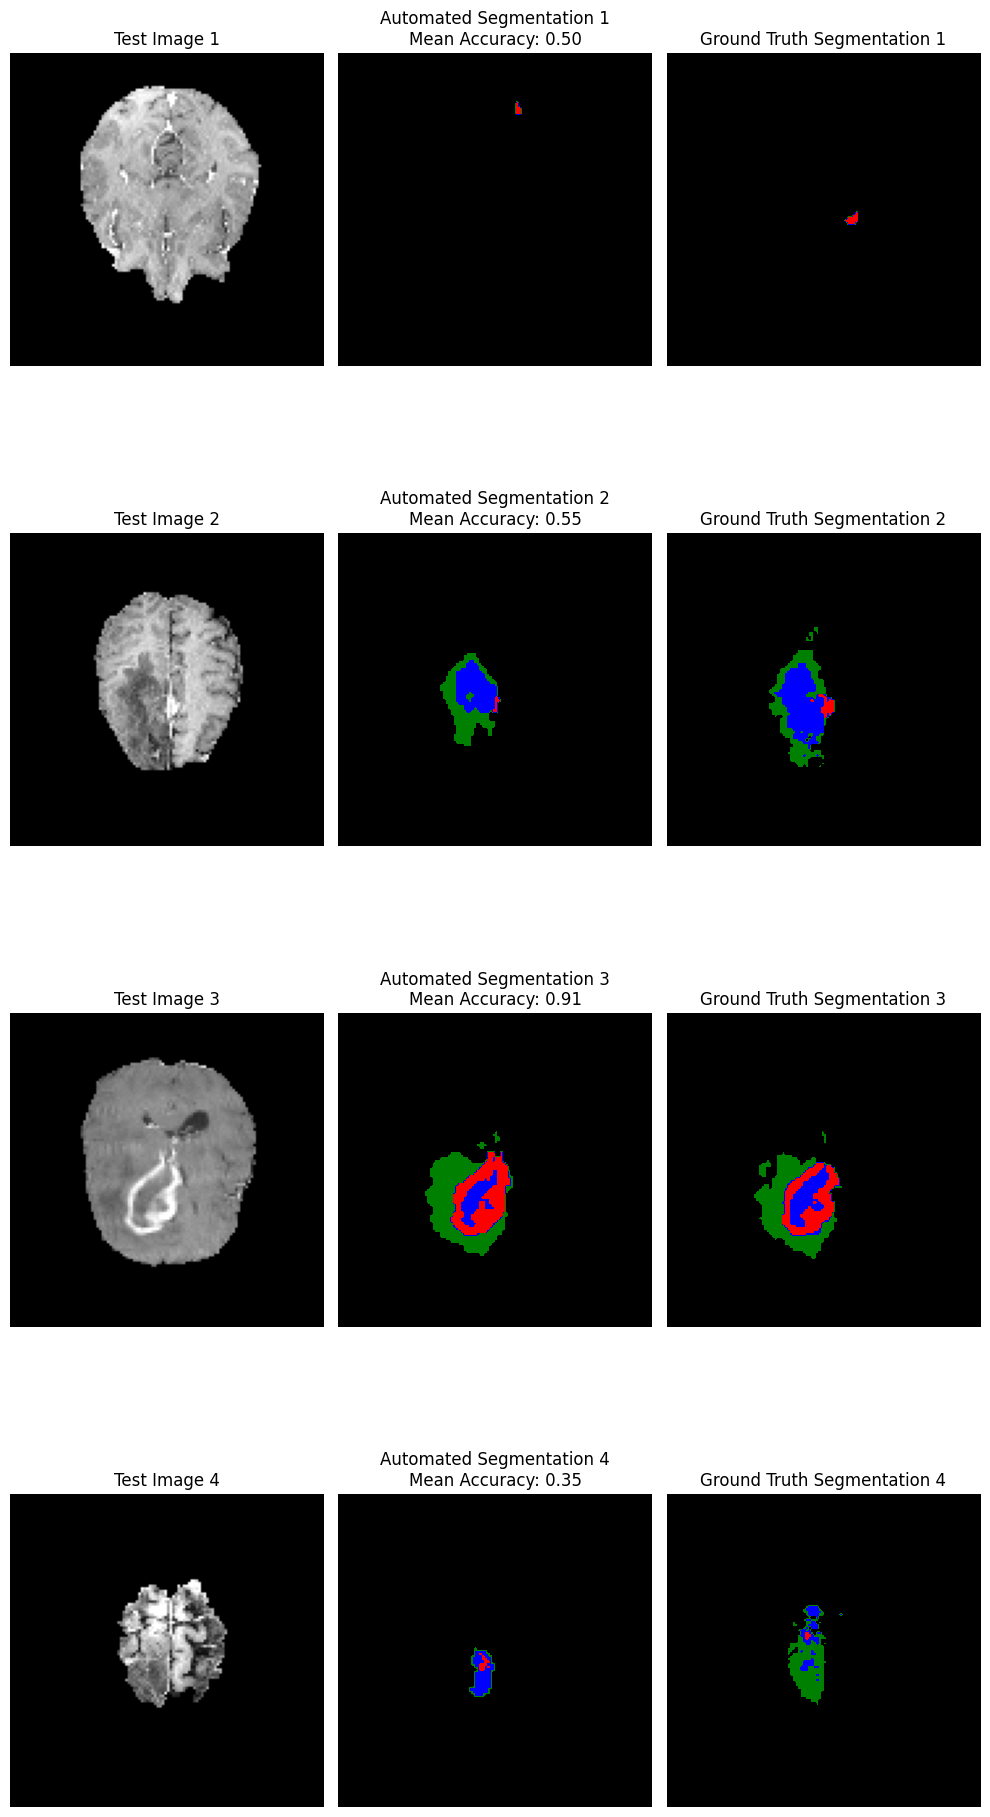

In [ ]:
# Per-class pixel accuracy
def pixel_accuracy_per_class(prediction, label, num_classes):
    accuracies = []
    for cls in range(num_classes):
        cls_mask = label == cls
        correct_cls = np.sum((prediction == cls) & cls_mask)
        total_cls = np.sum(cls_mask)
        if total_cls == 0:
            acc = np.nan
        else:
            acc = correct_cls / total_cls
        accuracies.append(acc)
    return accuracies

# Visualise the images and calculate pixel accuracy per class
figure, axes = plt.subplots(deploy_batch_size, 3, figsize=(10, 20))

for i in range(deploy_batch_size):
    image = deploy_images[i].cpu().numpy().squeeze(0)
    label = ground_truth_labels[i].cpu().numpy()
    prediction = predictions[i].cpu().numpy()

    # Per-class pixel accuracy
    per_class_acc = pixel_accuracy_per_class(prediction, label, num_classes)
    # Calculate mean accuracy
    mean_acc = np.nanmean(per_class_acc)

    # Display image
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Test Image {i+1}')

    # Use a custom colormap for label visualization
    label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
    axes[i, 1].imshow(prediction, cmap=label_cmap)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Automated Segmentation {i+1}\nMean Accuracy: {mean_acc:.2f}')

    axes[i, 2].imshow(label, cmap=label_cmap)
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f'Ground Truth Segmentation {i+1}')

plt.tight_layout()
plt.show()


## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

In the evaluation of  this deep learning model designed for pixel-wise classification within medical imaging, particularly in the segmentation of brain images, several key observations were made. The model's capability to assign each pixel to one of four classes, aimed at facilitating the detailed analysis of medical images, was demonstrated effectively. This process is critical for identifying pathological conditions such as tumours or oedema within the brain, which are pivotal for accurate diagnosis and subsequent treatment planning.

The model's performance was assessed through its ability to minimise cross-entropy loss. The observed training loss exhibited a sharp decline initially, suggesting that the model was rapidly learning from the training dataset. This decline plateaued over time, indicating a stabilisation in learning and suggesting that the model was beginning to fit well to the training data.

However, the behaviour of the model on test data presented a slightly different narrative. Although a similar sharp decline in loss was observed, indicating good generalisation capabilities initially, the test loss fluctuated more than the training loss. This fluctuation could indicate the model's slight overfitting to the training data or the presence of noise within the test dataset. Despite these fluctuations, the overall low level of loss on the test data suggests that the model retains a relatively good performance on unseen data.

Visual inspection of the model's segmented images revealed its ability to identify regions of interest corresponding to various tumour regions within the brain. However, the model's segmentation did not always align perfectly with the ground truth, particularly in the accurate localisation of tumour regions.

In some cases, the model correctly identified the presence of a feature of interest but misplaced it within the brain. For example, test image 1 is predicting correctly that there is an enhancing tumour, but it is placing it in the wrong region of the brain (which in a clinical environment would be a dangerous prediction). When it does get the correct region of the brain, as seen in test image 3, there is some discrepancy in the predicted tumour boundary compared to the ground truth. Such inaccuracies, especially in a clinical environment, highlight the need for improved precision in the model's predictions.

Further complicating the model's evaluation is the observed variability in mean accuracy per class across different images, which ranged significantly. In the above random batch, it varies from 0.35 to 0.91. This inconsistency in performance underscores the challenge of deploying such models in clinical settings, where high reliability and accuracy are imperative for patient safety and effective diagnosis.

One possible explanation could be that on observation of the images, there are some where the impacted region can clearly be identified in the original image, making segmentation seemingly easier. However, there are some images where the presence of the tumour (confirmed by the labelled image) is more subtle or not noticeable, hence it would be difficult for the model to accurately segment the different classes.

To address these challenges and improve the model's clinical applicability, several improvements are proposed. Data augmentation techniques, such as applying affine transformations to the training images, could enhance the model's ability to generalise by providing a more diverse dataset for training.
Advanced architectures like U-Net++ may offer superior feature extraction capabilities, potentially improving segmentation accuracy. Exploring alternative loss functions, or a combination thereof, could provide a more nuanced optimisation strategy, particularly for addressing class imbalance or emphasising segmentation boundaries.

Collaboration with clinical experts throughout the model development process can provide invaluable real-world insights, ensuring that the model's training and evaluation align closely with clinical realities. Such iterative feedback can guide the refinement of the model, enhancing its performance and reliability.

Some considerations when deploying to the clinic would be:

* The model needs to be validated on a more diverse and representative dataset, given the natural diversity amongst patients to make the model more adaptive
* A key point to note is that the clinicians using the predictions to assist their diagnoses will not have significant technical knowledge to be able to understand how the model works, hence the model will need to be as interpretable as possible. Doctors will need to trust that the model is robust and reliable
* Having an uncertainty estimation or confidence estimation when making a prediction would help clinicians place a weight on the amount they use the prediction in their diagnosis

Overall, the model can classify images into the four classes on a pixel-wise basis to varying degrees of accuracy. With improvements, significantly more training and collaboration with clinicians there is a path towards it becoming clinically viable.